In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry.polygon import Polygon
from h3 import h3 
from shapely.geometry import shape
from shapely.geometry import Point

In [2]:
#nur die daten von 2017 einlesen, schon leicht bearbeitet(taxi id neu und trio id geloescht)
df=pd.read_csv('merge2.csv')
df

,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,...,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,new_TaxiID
0,01/01/2017 12:00:00 AM,01/01/2017 12:00:00 AM,480.0,1.50,NaN,1.703108e+10,NaN,8.0,7.50,0.0,...,9.00,Cash,Dispatch Taxi Affiliation,NaN,NaN,NaN,41.905858,-87.630865,POINT (-87.6308650266 41.9058577688),1333
1,01/01/2017 12:00:00 AM,01/01/2017 12:00:00 AM,0.0,0.00,NaN,NaN,NaN,NaN,27.00,0.0,...,27.00,Credit Card,Suburban Dispatch LLC,NaN,NaN,NaN,NaN,NaN,NaN,2190
2,01/01/2017 12:00:00 AM,01/01/2017 12:45:00 AM,2280.0,0.20,NaN,NaN,NaN,76.0,22.25,0.0,...,22.25,Cash,Dispatch Taxi Affiliation,NaN,NaN,NaN,41.980264,-87.913625,POINT (-87.913624596 41.9802643146),3316
3,01/01/2017 12:00:00 AM,01/01/2017 12:00:00 AM,480.0,1.70,NaN,NaN,NaN,NaN,7.50,0.0,...,7.50,Cash,4787 - 56058 Reny Cab Co,NaN,NaN,NaN,NaN,NaN,NaN,5349
4,01/01/2017 12:00:00 AM,01/01/2017 12:00:00 AM,540.0,0.00,NaN,NaN,NaN,NaN,6.75,0.0,...,7.75,Cash,Blue Ribbon Taxi Association Inc.,NaN,NaN,NaN,NaN,NaN,NaN,4998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24979606,12/31/2017 11:45:00 PM,12/31/2017 11:45:00 PM,660.0,6.10,NaN,NaN,NaN,NaN,17.50,3.9,...,23.90,Credit Card,Sun Taxi,NaN,NaN,NaN,NaN,NaN,NaN,2080
24979607,12/31/2017 11:45:00 PM,01/01/2018 12:30:00 AM,2100.0,10.74,NaN,1.703103e+10,NaN,77.0,30.75,0.0,...,32.25,Cash,Taxi Affiliation Service Yellow,NaN,NaN,NaN,41.994442,-87.665225,POINT (-87.6652247765 41.9944422482),4011
24979608,12/31/2017 11:45:00 PM,12/31/2017 11:45:00 PM,420.0,1.70,NaN,NaN,NaN,NaN,7.75,2.0,...,11.25,Credit Card,Medallion Leasin,NaN,NaN,NaN,NaN,NaN,NaN,890
24979609,12/31/2017 11:45:00 PM,01/01/2018 12:00:00 AM,682.0,2.30,NaN,NaN,NaN,NaN,9.75,0.0,...,10.75,Cash,Checker Taxi Affiliation,NaN,NaN,NaN,NaN,NaN,NaN,3225


In [3]:
#kreirt zwei dummy variablen, zum vergleichen spaeter
tage=["2017-01-01 00:00:00",'2017-01-02 00:00:00',"2017-01-01 00:00:00",'2017-01-01 16:00:00']
tage=pd.to_datetime(tage)
tag=tage[1]-tage[0]
halbertag=tage[3]-tage[2]

halbertag

Timedelta('0 days 16:00:00')

# Achtung folgende zelle dauert etwa 10 min

In [4]:
# Achtung folgende zelle dauert etwa 10 min

#from am/pm to 24 hour time
df.loc[:, 'Trip Start Timestamp']=pd.to_datetime(df['Trip Start Timestamp'])
#from am/pm to 24 hour time
df.loc[:, 'Trip End Timestamp']=pd.to_datetime(df['Trip End Timestamp'])


In [5]:
#dropt alle zeilen, deren end timestamp vor der start timestamp sind, dies sind nur 30 eintraege also
#statistisch nicht relevant und auch kein durchlaufender gleicher fehler zu erkennen, mit dem man die daten
#"reparieren koennte"
df=df.drop(df[df['Trip End Timestamp']<df['Trip Start Timestamp']].index)

In [6]:
#kreirt zwei dummy variablen, zum vergleichen spaeter
tage=["2017-01-01 00:00:00",'2017-01-02 00:00:00',"2017-01-01 00:00:00",'2017-01-01 16:00:00']
tage=pd.to_datetime(tage)
tag=tage[1]-tage[0]
halbertag=tage[3]-tage[2]

halbertag

Timedelta('0 days 16:00:00')

In [7]:
#gucke an welche trips laenger als 16 stunden sind
df[df['Trip End Timestamp']-df['Trip Start Timestamp']>halbertag]

,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,...,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,new_TaxiID
2319,2017-01-01 00:30:00,2017-01-02 00:00:00,85020.0,0.00,1.703108e+10,1.703108e+10,8.0,8.0,0.00,0.0,...,0.00,Cash,Patriot Taxi Dba Peace Taxi Associat,41.898332,-87.620763,POINT (-87.6207628651 41.8983317935),41.898332,-87.620763,POINT (-87.6207628651 41.8983317935),263
3268,2017-01-01 00:30:00,2017-01-01 22:30:00,78624.0,0.00,NaN,NaN,NaN,49.0,6.50,0.0,...,8.00,Cash,Chicago Carriage Cab Corp,NaN,NaN,NaN,41.706588,-87.623367,POINT (-87.6233665115 41.7065878819),2210
12020,2017-01-01 02:00:00,2017-01-01 22:15:00,73278.0,1.29,1.703108e+10,1.703184e+10,8.0,32.0,6.75,3.0,...,10.25,Credit Card,Chicago Carriage Cab Corp,41.902788,-87.626146,POINT (-87.6261455896 41.9027880476),41.880994,-87.632746,POINT (-87.6327464887 41.8809944707),2935
15462,2017-01-01 02:30:00,2017-01-01 19:45:00,62583.0,2.79,NaN,NaN,34.0,31.0,10.75,0.0,...,10.75,Cash,Chicago Carriage Cab Corp,41.842076,-87.633973,POINT (-87.6339734222 41.8420761168),41.850266,-87.667569,POINT (-87.667569312 41.8502663663),3597
16778,2017-01-01 02:45:00,2017-01-02 02:00:00,83700.0,0.00,1.703108e+10,1.703108e+10,8.0,8.0,25.00,0.0,...,25.50,Credit Card,Globe Taxi,41.890922,-87.618868,POINT (-87.6188683546 41.8909220259),41.892073,-87.628874,POINT (-87.6288741572 41.8920726347),979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24949224,2017-12-30 23:00:00,2017-12-31 16:00:00,61320.0,1088.20,1.703184e+10,1.703132e+10,32.0,32.0,5239.51,0.0,...,5301.59,Cash,Globe Taxi,41.880994,-87.632746,POINT (-87.6327464887 41.8809944707),41.877406,-87.621972,POINT (-87.6219716519 41.8774061234),5250
24958430,2017-12-31 11:00:00,2018-01-01 12:00:00,NaN,0.00,NaN,NaN,3.0,NaN,3.25,0.0,...,3.25,Cash,Taxi Affiliation Service Yellow,41.965812,-87.655879,POINT (-87.6558787862 41.96581197),NaN,NaN,NaN,5785
24965722,2017-12-31 16:30:00,2018-01-01 17:15:00,NaN,0.00,1.703184e+10,NaN,32.0,NaN,3.25,0.0,...,3.25,Cash,Sun Taxi,41.880994,-87.632746,POINT (-87.6327464887 41.8809944707),NaN,NaN,NaN,809
24967192,2017-12-31 17:15:00,2018-01-01 10:15:00,61031.0,0.00,NaN,NaN,NaN,1.0,34.25,0.0,...,34.25,Cash,Patriot Taxi Dba Peace Taxi Associat,NaN,NaN,NaN,42.009623,-87.670167,POINT (-87.67016685690001 42.0096228806),6637


In [8]:
#die 1600 eintraege, die laenger als 16 stunden sind sehen unserioes aus, weg damit
df=df.drop(df[df['Trip End Timestamp']-df['Trip Start Timestamp']>halbertag].index)

In [9]:
df.count()

Trip Start Timestamp          24977441
Trip End Timestamp            24976784
Trip Seconds                  24976669
Trip Miles                    24976959
Pickup Census Tract           16930286
Dropoff Census Tract          16844524
Pickup Community Area         22676616
Dropoff Community Area        22221651
Fare                          24976854
Tips                          24976854
Tolls                         17998308
Extras                        24976854
Trip Total                    24976854
Payment Type                  24977441
Company                       24977441
Pickup Centroid Latitude      22681078
Pickup Centroid Longitude     22681078
Pickup Centroid Location      22681078
Dropoff Centroid Latitude     22292804
Dropoff Centroid Longitude    22292804
Dropoff Centroid  Location    22292804
new_TaxiID                    24977441
dtype: int64

In [10]:
#da ist ein lehrzeichen zu viel!
df=df.rename(columns={'Dropoff Centroid  Location':'Dropoff Centroid Location'})

In [11]:
#es gibt ein paar duplikate, weg damit
df=df.drop_duplicates()

In [12]:
df.count()

Trip Start Timestamp          24945743
Trip End Timestamp            24945089
Trip Seconds                  24944974
Trip Miles                    24945261
Pickup Census Tract           16914619
Dropoff Census Tract          16828734
Pickup Community Area         22662570
Dropoff Community Area        22207448
Fare                          24945157
Tips                          24945157
Tolls                         17984867
Extras                        24945157
Trip Total                    24945157
Payment Type                  24945743
Company                       24945743
Pickup Centroid Latitude      22666901
Pickup Centroid Longitude     22666901
Pickup Centroid Location      22666901
Dropoff Centroid Latitude     22278470
Dropoff Centroid Longitude    22278470
Dropoff Centroid Location     22278470
new_TaxiID                    24945743
dtype: int64

In [13]:
#es fehlen etwa 1.000 eintraege die end zeit, auch weg damit sind so wenige, dass ist nicht ganz so schlimm
df=df.drop(df[df['Trip End Timestamp'].isna()].index)

In [14]:
df.count()

Trip Start Timestamp          24945089
Trip End Timestamp            24945089
Trip Seconds                  24944974
Trip Miles                    24944607
Pickup Census Tract           16914131
Dropoff Census Tract          16828734
Pickup Community Area         22661972
Dropoff Community Area        22207448
Fare                          24944503
Tips                          24944503
Tolls                         17984213
Extras                        24944503
Trip Total                    24944503
Payment Type                  24945089
Company                       24945089
Pickup Centroid Latitude      22666302
Pickup Centroid Longitude     22666302
Pickup Centroid Location      22666302
Dropoff Centroid Latitude     22278470
Dropoff Centroid Longitude    22278470
Dropoff Centroid Location     22278470
new_TaxiID                    24945089
dtype: int64

In [15]:
#unter 120 eintraege werden geloescht, und sie sind alle eher klein/oder sogar fehlerhaft
df=df.drop(df[df['Trip Seconds'].isna()].index)
#mit folgender spalte kann man etwas klarer sehen wie lange die trips sind, es rechnet einfach die minuten
#aus den sekunden aus
df['dur_min']=df['Trip Seconds'].apply(lambda x:round(x/60,2))

In [16]:
df.count()

Trip Start Timestamp          24944974
Trip End Timestamp            24944974
Trip Seconds                  24944974
Trip Miles                    24944494
Pickup Census Tract           16914095
Dropoff Census Tract          16828677
Pickup Community Area         22661934
Dropoff Community Area        22207378
Fare                          24944426
Tips                          24944426
Tolls                         17984173
Extras                        24944426
Trip Total                    24944426
Payment Type                  24944974
Company                       24944974
Pickup Centroid Latitude      22666264
Pickup Centroid Longitude     22666264
Pickup Centroid Location      22666264
Dropoff Centroid Latitude     22278399
Dropoff Centroid Longitude    22278399
Dropoff Centroid Location     22278399
new_TaxiID                    24944974
dur_min                       24944974
dtype: int64

In [17]:
#wieder etwa 500 eintaege weg, habe mir die angeguckt, wenn kein eintrag bei fare war waren auch oft andere
#werte komisch
df=df.drop(df[df['Fare'].isna()].index)

In [18]:
df.count()

Trip Start Timestamp          24944426
Trip End Timestamp            24944426
Trip Seconds                  24944426
Trip Miles                    24944393
Pickup Census Tract           16913690
Dropoff Census Tract          16828277
Pickup Community Area         22661463
Dropoff Community Area        22206924
Fare                          24944426
Tips                          24944426
Tolls                         17984173
Extras                        24944426
Trip Total                    24944426
Payment Type                  24944426
Company                       24944426
Pickup Centroid Latitude      22665793
Pickup Centroid Longitude     22665793
Pickup Centroid Location      22665793
Dropoff Centroid Latitude     22277945
Dropoff Centroid Longitude    22277945
Dropoff Centroid Location     22277945
new_TaxiID                    24944426
dur_min                       24944426
dtype: int64

In [19]:
#dit trips unter 30 sekunden betrachten
dfsmall=df[df['Trip Seconds']<30]

In [20]:
#von 1 mio trips sind nur 35tausend auch weiter als 0.2 meilen und haben mehr als die standart taxi uhr start kosten
#nur diese 35tausen behalten wir
dfsmall[(dfsmall['Trip Miles']>0.2) & (dfsmall['Fare']>3.25)]

,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,...,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,new_TaxiID,dur_min
1520,2017-01-01 00:15:00,2017-01-01 00:15:00,7.0,1.00,1.703108e+10,1.703108e+10,8.0,8.0,7.00,1.00,...,Credit Card,Flash Cab,41.900266,-87.632109,POINT (-87.6321092196 41.9002656868),41.900266,-87.632109,POINT (-87.6321092196 41.9002656868),4610,0.12
3312,2017-01-01 00:45:00,2017-01-01 00:45:00,0.0,0.28,NaN,NaN,NaN,NaN,3.75,0.00,...,Cash,Patriot Taxi Dba Peace Taxi Associat,NaN,NaN,NaN,NaN,NaN,NaN,5898,0.00
3876,2017-01-01 00:45:00,2017-01-01 00:45:00,0.0,0.40,NaN,NaN,22.0,16.0,4.25,0.00,...,Cash,Sun Taxi,41.922761,-87.699155,POINT (-87.69915534320002 41.9227606205),41.953582,-87.723452,POINT (-87.7234523905 41.9535821253),6629,0.00
6603,2017-01-01 01:15:00,2017-01-01 01:15:00,9.0,0.59,1.703132e+10,1.703132e+10,32.0,32.0,5.00,0.00,...,Cash,Chicago Carriage Cab Corp,41.877406,-87.621972,POINT (-87.6219716519 41.8774061234),41.877406,-87.621972,POINT (-87.6219716519 41.8774061234),6323,0.15
8172,2017-01-01 01:30:00,2017-01-01 01:30:00,1.0,1.49,1.703108e+10,1.703107e+10,8.0,7.0,6.75,0.00,...,Cash,Chicago Carriage Cab Corp,41.907492,-87.635760,POINT (-87.6357600901 41.9074919303),41.930579,-87.642206,POINT (-87.6422063127 41.9305785697),6806,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24970017,2017-12-31 18:45:00,2017-12-31 18:45:00,6.0,0.74,1.703108e+10,1.703108e+10,8.0,8.0,6.25,0.00,...,Cash,Chicago Carriage Cab Corp,41.890922,-87.618868,POINT (-87.6188683546 41.8909220259),41.890922,-87.618868,POINT (-87.6188683546 41.8909220259),1075,0.10
24970144,2017-12-31 18:45:00,2017-12-31 18:45:00,19.0,12.60,NaN,NaN,NaN,4.0,33.75,7.65,...,Credit Card,Taxi Affiliation Service Yellow,NaN,NaN,NaN,41.975171,-87.687516,POINT (-87.68751551520002 41.9751709433),5288,0.32
24971058,2017-12-31 19:15:00,2017-12-31 19:15:00,0.0,0.50,1.703132e+10,1.703132e+10,32.0,32.0,4.50,0.00,...,Cash,Sun Taxi,41.884987,-87.620993,POINT (-87.6209929134 41.8849871918),41.884987,-87.620993,POINT (-87.6209929134 41.8849871918),1462,0.00
24975159,2017-12-31 21:15:00,2017-12-31 21:15:00,4.0,5.01,NaN,NaN,7.0,7.0,17.25,0.00,...,Cash,Sun Taxi,41.922686,-87.649489,POINT (-87.6494887289 41.9226862843),41.922686,-87.649489,POINT (-87.6494887289 41.9226862843),5908,0.07


In [21]:
dfsmall=dfsmall.drop(dfsmall[(dfsmall['Trip Miles']>0.2) & (dfsmall['Fare']>3.25)].index)

In [22]:
df=df.drop(dfsmall.index)

In [23]:
df.count()

Trip Start Timestamp          23883058
Trip End Timestamp            23883058
Trip Seconds                  23883058
Trip Miles                    23883033
Pickup Census Tract           16464418
Dropoff Census Tract          16392543
Pickup Community Area         21987474
Dropoff Community Area        21548912
Fare                          23883058
Tips                          23883058
Tolls                         17433221
Extras                        23883058
Trip Total                    23883058
Payment Type                  23883058
Company                       23883058
Pickup Centroid Latitude      21989227
Pickup Centroid Longitude     21989227
Pickup Centroid Location      21989227
Dropoff Centroid Latitude     21617287
Dropoff Centroid Longitude    21617287
Dropoff Centroid Location     21617287
new_TaxiID                    23883058
dur_min                       23883058
dtype: int64

In [24]:
#schmeiße alles raus was keine trip seconds hat, das sind nur 18. tausend!
df=df.drop(df[df['Trip Seconds']==0].index)

In [25]:
df.count()

Trip Start Timestamp          23864715
Trip End Timestamp            23864715
Trip Seconds                  23864715
Trip Miles                    23864690
Pickup Census Tract           16456660
Dropoff Census Tract          16383687
Pickup Community Area         21974595
Dropoff Community Area        21534625
Fare                          23864715
Tips                          23864715
Tolls                         17420658
Extras                        23864715
Trip Total                    23864715
Payment Type                  23864715
Company                       23864715
Pickup Centroid Latitude      21976304
Pickup Centroid Longitude     21976304
Pickup Centroid Location      21976304
Dropoff Centroid Latitude     21602917
Dropoff Centroid Longitude    21602917
Dropoff Centroid Location     21602917
new_TaxiID                    23864715
dur_min                       23864715
dtype: int64

In [26]:
#since fare+tipps+tolls+extras=Trip Total bei allen stimmt(und nan=0)kann 
#ich die fehlenden tolls mit nullen auffuellen(hatte das geprueft)
df.loc[:,'Tolls']=df.loc[:,'Tolls'].fillna(0)

In [27]:
df.count()

Trip Start Timestamp          23864715
Trip End Timestamp            23864715
Trip Seconds                  23864715
Trip Miles                    23864690
Pickup Census Tract           16456660
Dropoff Census Tract          16383687
Pickup Community Area         21974595
Dropoff Community Area        21534625
Fare                          23864715
Tips                          23864715
Tolls                         23864715
Extras                        23864715
Trip Total                    23864715
Payment Type                  23864715
Company                       23864715
Pickup Centroid Latitude      21976304
Pickup Centroid Longitude     21976304
Pickup Centroid Location      21976304
Dropoff Centroid Latitude     21602917
Dropoff Centroid Longitude    21602917
Dropoff Centroid Location     21602917
new_TaxiID                    23864715
dur_min                       23864715
dtype: int64

In [28]:
#hier wird geldwaesche betrieben, ueber 1000 euro zahlen und unter 3 stunden unterwegs zu sein macht keinen sinn.
#es sind nur 700 fahrten also wahrscheinich nicht sehr aussage kraeftig, aber solche ausreiser aus dem datensatz
#brauchen wir trotzdem nicht
test=df[df['Trip Total']>1000]
delete=test[test['Trip Seconds']<18000].index
df=df.drop(delete)

In [29]:
df.count()

Trip Start Timestamp          23864015
Trip End Timestamp            23864015
Trip Seconds                  23864015
Trip Miles                    23863990
Pickup Census Tract           16456205
Dropoff Census Tract          16383234
Pickup Community Area         21973957
Dropoff Community Area        21534009
Fare                          23864015
Tips                          23864015
Tolls                         23864015
Extras                        23864015
Trip Total                    23864015
Payment Type                  23864015
Company                       23864015
Pickup Centroid Latitude      21975666
Pickup Centroid Longitude     21975666
Pickup Centroid Location      21975666
Dropoff Centroid Latitude     21602300
Dropoff Centroid Longitude    21602300
Dropoff Centroid Location     21602300
new_TaxiID                    23864015
dur_min                       23864015
dtype: int64

In [30]:
df[(df['Trip Miles']==0) & (df['Fare']<=3.25)]

,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,...,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,new_TaxiID,dur_min
50,2017-01-01 00:00:00,2017-01-01 00:00:00,60.0,0.0,1.703108e+10,1.703108e+10,8.0,8.0,3.25,0.00,...,Cash,Choice Taxi Association,41.892508,-87.626215,POINT (-87.6262149064 41.8925077809),41.892508,-87.626215,POINT (-87.6262149064 41.8925077809),5577,1.00
147,2017-01-01 00:00:00,2017-01-01 00:00:00,60.0,0.0,1.703108e+10,1.703108e+10,8.0,8.0,3.25,0.00,...,Cash,Choice Taxi Association,41.890922,-87.618868,POINT (-87.6188683546 41.8909220259),41.890922,-87.618868,POINT (-87.6188683546 41.8909220259),217,1.00
340,2017-01-01 00:00:00,2017-01-01 00:00:00,60.0,0.0,1.703184e+10,1.703184e+10,24.0,24.0,3.25,0.00,...,Cash,Taxi Affiliation Service Yellow,41.898306,-87.653614,POINT (-87.6536139825 41.8983058696),41.898306,-87.653614,POINT (-87.6536139825 41.8983058696),5069,1.00
1096,2017-01-01 00:15:00,2017-01-01 00:30:00,867.0,0.0,1.703108e+10,NaN,8.0,NaN,3.25,0.00,...,Cash,Chicago Carriage Cab Corp,41.893216,-87.637844,POINT (-87.6378442095 41.8932163595),NaN,NaN,NaN,3174,14.45
1850,2017-01-01 00:15:00,2017-01-01 00:15:00,60.0,0.0,NaN,NaN,NaN,NaN,3.25,0.00,...,Cash,Patriot Taxi Dba Peace Taxi Associat,NaN,NaN,NaN,NaN,NaN,NaN,1855,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24978868,2017-12-31 23:30:00,2017-12-31 23:30:00,60.0,0.0,1.703108e+10,1.703108e+10,8.0,8.0,3.25,0.00,...,Cash,Choice Taxi Association,41.893216,-87.637844,POINT (-87.6378442095 41.8932163595),41.893216,-87.637844,POINT (-87.6378442095 41.8932163595),6155,1.00
24979189,2017-12-31 23:30:00,2017-12-31 23:30:00,34.0,0.0,NaN,NaN,56.0,56.0,3.25,0.00,...,Cash,Taxi Affiliation Service Yellow,41.792592,-87.769615,POINT (-87.7696154528 41.7925923603),41.792592,-87.769615,POINT (-87.7696154528 41.7925923603),6607,0.57
24979228,2017-12-31 23:30:00,2017-12-31 23:30:00,76.0,0.0,1.703184e+10,1.703184e+10,27.0,27.0,3.25,0.00,...,Cash,Checker Taxi Affiliation,41.885621,-87.698892,POINT (-87.6988915914 41.885621155),41.885621,-87.698892,POINT (-87.6988915914 41.885621155),1487,1.27
24979281,2017-12-31 23:45:00,2017-12-31 23:45:00,60.0,0.0,NaN,NaN,6.0,6.0,3.25,0.00,...,Cash,Taxi Affiliation Services,41.944227,-87.655998,POINT (-87.6559981815 41.9442266014),41.944227,-87.655998,POINT (-87.6559981815 41.9442266014),5646,1.00


In [31]:
#die 130 tausend sehen auch faul aus, ist zwar nicht wenig aber macht trotzdem einen unterschied

In [32]:
df=df.drop(df[(df['Trip Miles']==0) & (df['Fare']<=3.25)].index)

In [33]:
df.count()

Trip Start Timestamp          23731747
Trip End Timestamp            23731747
Trip Seconds                  23731747
Trip Miles                    23731722
Pickup Census Tract           16383336
Dropoff Census Tract          16312622
Pickup Community Area         21869316
Dropoff Community Area        21431847
Fare                          23731747
Tips                          23731747
Tolls                         23731747
Extras                        23731747
Trip Total                    23731747
Payment Type                  23731747
Company                       23731747
Pickup Centroid Latitude      21870695
Pickup Centroid Longitude     21870695
Pickup Centroid Location      21870695
Dropoff Centroid Latitude     21499792
Dropoff Centroid Longitude    21499792
Dropoff Centroid Location     21499792
new_TaxiID                    23731747
dur_min                       23731747
dtype: int64

In [34]:
#die 30 fehlenden trip miles raushauen, weil 30 eintraeger statistisch nicht so wichtig sind.
df=df[df['Trip Miles'].notna()]

In [35]:
df.count()

Trip Start Timestamp          23731722
Trip End Timestamp            23731722
Trip Seconds                  23731722
Trip Miles                    23731722
Pickup Census Tract           16383324
Dropoff Census Tract          16312609
Pickup Community Area         21869293
Dropoff Community Area        21431824
Fare                          23731722
Tips                          23731722
Tolls                         23731722
Extras                        23731722
Trip Total                    23731722
Payment Type                  23731722
Company                       23731722
Pickup Centroid Latitude      21870672
Pickup Centroid Longitude     21870672
Pickup Centroid Location      21870672
Dropoff Centroid Latitude     21499769
Dropoff Centroid Longitude    21499769
Dropoff Centroid Location     21499769
new_TaxiID                    23731722
dur_min                       23731722
dtype: int64

## hier drunter stehen 2 mio fahrten, die irgendwie komische preise haben, aber da die preise kaum verwendet werden später lassen wir die mal drinnen.

In [36]:
#kosten der fahrt die unter 3,25 sind, das ist glaube ich eigentlich die start kosten einer taxi uhr...
df[df['Fare']<3.25]

,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,...,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,new_TaxiID,dur_min
2185,2017-01-01 00:30:00,2017-01-01 01:00:00,2114.0,18.00,NaN,NaN,NaN,NaN,0.01,0.00,...,Cash,303 Taxi,NaN,NaN,NaN,NaN,NaN,NaN,4718,35.23
3039,2017-01-01 00:30:00,2017-01-01 00:45:00,1158.0,16.10,NaN,NaN,76.0,NaN,0.01,0.00,...,Cash,303 Taxi,41.980264,-87.913625,POINT (-87.913624596 41.9802643146),NaN,NaN,NaN,959,19.30
3043,2017-01-01 00:30:00,2017-01-01 00:45:00,824.0,12.90,NaN,NaN,76.0,NaN,0.01,8.00,...,Credit Card,303 Taxi,41.980264,-87.913625,POINT (-87.913624596 41.9802643146),NaN,NaN,NaN,5847,13.73
4597,2017-01-01 00:45:00,2017-01-01 01:30:00,1995.0,16.60,NaN,NaN,NaN,5.0,0.01,0.00,...,Cash,303 Taxi,NaN,NaN,NaN,41.947792,-87.683835,POINT (-87.6838349425 41.9477915865),5144,33.25
4601,2017-01-01 00:45:00,2017-01-01 00:45:00,114.0,0.60,NaN,NaN,NaN,NaN,3.20,0.00,...,Cash,303 Taxi,NaN,NaN,NaN,NaN,NaN,NaN,1920,1.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24952817,2017-12-31 01:15:00,2017-12-31 01:30:00,740.0,1.40,NaN,NaN,6.0,3.0,2.00,0.00,...,Cash,Taxi Affiliation Service Yellow,41.944227,-87.655998,POINT (-87.6559981815 41.9442266014),41.965812,-87.655879,POINT (-87.6558787862 41.96581197),2614,12.33
24955923,2017-12-31 05:15:00,2017-12-31 06:00:00,2280.0,0.10,NaN,NaN,8.0,8.0,0.00,0.00,...,Cash,Taxi Affiliation Services,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.899602,-87.633308,POINT (-87.6333080367 41.899602111),3209,38.00
24957107,2017-12-31 09:15:00,2017-12-31 11:00:00,5756.0,7.13,NaN,NaN,NaN,56.0,1.00,8.25,...,Cash,Chicago Carriage Cab Corp,NaN,NaN,NaN,41.792592,-87.769615,POINT (-87.7696154528 41.7925923603),3389,95.93
24969140,2017-12-31 18:15:00,2017-12-31 18:30:00,540.0,0.70,1.703128e+10,1.703132e+10,28.0,32.0,0.00,0.00,...,Cash,Taxi Affiliation Service Yellow,41.885300,-87.642808,POINT (-87.6428084655 41.8853000224),41.884987,-87.620993,POINT (-87.6209929134 41.8849871918),2494,9.00


In [37]:
#trips die unter einer minute sind
nominute=df[df['Trip Seconds']<60]

In [38]:
nominute

,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,...,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,new_TaxiID,dur_min
378,2017-01-01 00:00:00,2017-01-01 00:00:00,41.0,0.01,1.703108e+10,1.703108e+10,8.0,8.0,3.25,0.0,...,Cash,Chicago Carriage Cab Corp,41.898332,-87.620763,POINT (-87.6207628651 41.8983317935),41.898332,-87.620763,POINT (-87.6207628651 41.8983317935),4335,0.68
1518,2017-01-01 00:15:00,2017-01-01 00:15:00,58.0,0.10,1.703108e+10,1.703108e+10,8.0,8.0,3.50,0.0,...,Cash,Flash Cab,41.899156,-87.626211,POINT (-87.6262105324 41.8991556134),41.898332,-87.620763,POINT (-87.6207628651 41.8983317935),7102,0.97
1520,2017-01-01 00:15:00,2017-01-01 00:15:00,7.0,1.00,1.703108e+10,1.703108e+10,8.0,8.0,7.00,1.0,...,Credit Card,Flash Cab,41.900266,-87.632109,POINT (-87.6321092196 41.9002656868),41.900266,-87.632109,POINT (-87.6321092196 41.9002656868),4610,0.12
2733,2017-01-01 00:30:00,2017-01-01 00:30:00,50.0,0.22,1.703107e+10,1.703107e+10,7.0,7.0,3.75,0.0,...,Cash,Chicago Carriage Cab Corp,41.914616,-87.631717,POINT (-87.6317173661 41.9146162864),41.914616,-87.631717,POINT (-87.6317173661 41.9146162864),3508,0.83
3525,2017-01-01 00:45:00,2017-01-01 00:45:00,51.0,0.11,1.703184e+10,1.703184e+10,32.0,32.0,3.50,0.0,...,Cash,Chicago Carriage Cab Corp,41.880994,-87.632746,POINT (-87.6327464887 41.8809944707),41.880994,-87.632746,POINT (-87.6327464887 41.8809944707),4054,0.85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24975681,2017-12-31 21:30:00,2017-12-31 21:30:00,32.0,0.14,NaN,NaN,4.0,4.0,3.50,0.0,...,Cash,Patriot Taxi Dba Peace Taxi Associat,41.975171,-87.687516,POINT (-87.68751551520002 41.9751709433),41.975171,-87.687516,POINT (-87.68751551520002 41.9751709433),3281,0.53
24978368,2017-12-31 23:00:00,2017-12-31 23:00:00,40.0,0.05,1.703108e+10,1.703108e+10,8.0,8.0,3.25,2.0,...,Cash,City Service,41.890922,-87.618868,POINT (-87.6188683546 41.8909220259),41.890922,-87.618868,POINT (-87.6188683546 41.8909220259),5689,0.67
24979210,2017-12-31 23:30:00,2017-12-31 23:30:00,37.0,0.01,1.703108e+10,1.703108e+10,8.0,8.0,3.25,0.0,...,Cash,Taxi Affiliation Service Yellow,41.907492,-87.635760,POINT (-87.6357600901 41.9074919303),41.907492,-87.635760,POINT (-87.6357600901 41.9074919303),5606,0.62
24979225,2017-12-31 23:30:00,2017-12-31 23:30:00,47.0,0.10,1.703108e+10,1.703108e+10,8.0,8.0,3.25,0.0,...,Cash,Blue Diamond,41.905858,-87.630865,POINT (-87.6308650266 41.9058577688),41.900221,-87.629105,POINT (-87.6291051864 41.9002212967),3776,0.78


In [39]:
#unter einer minute und unter 3.25 fare haben..
nominute[nominute['Fare']<=3.25]

,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,...,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,new_TaxiID,dur_min
378,2017-01-01 00:00:00,2017-01-01 00:00:00,41.0,0.01,1.703108e+10,1.703108e+10,8.0,8.0,3.25,0.0,...,Cash,Chicago Carriage Cab Corp,41.898332,-87.620763,POINT (-87.6207628651 41.8983317935),41.898332,-87.620763,POINT (-87.6207628651 41.8983317935),4335,0.68
4608,2017-01-01 00:45:00,2017-01-01 00:45:00,43.0,0.10,NaN,NaN,NaN,NaN,2.40,0.0,...,Cash,303 Taxi,NaN,NaN,NaN,NaN,NaN,NaN,5801,0.72
5967,2017-01-01 01:00:00,2017-01-01 01:00:00,50.0,0.20,NaN,NaN,NaN,NaN,2.20,0.0,...,Cash,Norshore Cab,NaN,NaN,NaN,NaN,NaN,NaN,6946,0.83
7593,2017-01-01 01:15:00,2017-01-01 01:15:00,47.0,0.30,NaN,NaN,NaN,NaN,2.60,0.0,...,Cash,303 Taxi,NaN,NaN,NaN,NaN,NaN,NaN,5743,0.78
15783,2017-01-01 02:30:00,2017-01-01 02:30:00,46.0,0.20,NaN,NaN,15.0,15.0,2.20,0.0,...,Cash,303 Taxi,41.954028,-87.763399,POINT (-87.7633990316 41.9540276487),41.954028,-87.763399,POINT (-87.7633990316 41.9540276487),6662,0.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24973011,2017-12-31 20:15:00,2017-12-31 20:30:00,49.0,0.04,1.703108e+10,1.703108e+10,8.0,8.0,3.25,0.0,...,Cash,Chicago Carriage Cab Corp,41.890922,-87.618868,POINT (-87.6188683546 41.8909220259),41.890922,-87.618868,POINT (-87.6188683546 41.8909220259),1420,0.82
24974747,2017-12-31 21:00:00,2017-12-31 21:00:00,45.0,0.05,1.703106e+10,1.703106e+10,6.0,6.0,3.25,0.0,...,Cash,Chicago Carriage Cab Corp,41.942577,-87.647079,POINT (-87.6470785093 41.942577185),41.942577,-87.647079,POINT (-87.6470785093 41.942577185),3469,0.75
24978368,2017-12-31 23:00:00,2017-12-31 23:00:00,40.0,0.05,1.703108e+10,1.703108e+10,8.0,8.0,3.25,2.0,...,Cash,City Service,41.890922,-87.618868,POINT (-87.6188683546 41.8909220259),41.890922,-87.618868,POINT (-87.6188683546 41.8909220259),5689,0.67
24979210,2017-12-31 23:30:00,2017-12-31 23:30:00,37.0,0.01,1.703108e+10,1.703108e+10,8.0,8.0,3.25,0.0,...,Cash,Taxi Affiliation Service Yellow,41.907492,-87.635760,POINT (-87.6357600901 41.9074919303),41.907492,-87.635760,POINT (-87.6357600901 41.9074919303),5606,0.62


In [40]:
df=df.drop(nominute[nominute['Fare']<=3.25].index)

In [41]:
df.count()

Trip Start Timestamp          23718472
Trip End Timestamp            23718472
Trip Seconds                  23718472
Trip Miles                    23718472
Pickup Census Tract           16378741
Dropoff Census Tract          16308007
Pickup Community Area         21862371
Dropoff Community Area        21424792
Fare                          23718472
Tips                          23718472
Tolls                         23718472
Extras                        23718472
Trip Total                    23718472
Payment Type                  23718472
Company                       23718472
Pickup Centroid Latitude      21863715
Pickup Centroid Longitude     21863715
Pickup Centroid Location      21863715
Dropoff Centroid Latitude     21492706
Dropoff Centroid Longitude    21492706
Dropoff Centroid Location     21492706
new_TaxiID                    23718472
dur_min                       23718472
dtype: int64

# ab hier werden die Geodaten aufgeräumt und vervollständigt

In [42]:
#es fehlen bei 618.890 tausend eintraegen die geo daten des pickup also:
df=df[df['Pickup Centroid Latitude'].notna()]

In [43]:
df.count()

Trip Start Timestamp          21863715
Trip End Timestamp            21863715
Trip Seconds                  21863715
Trip Miles                    21863715
Pickup Census Tract           16373624
Dropoff Census Tract          16229741
Pickup Community Area         21862371
Dropoff Community Area        21212263
Fare                          21863715
Tips                          21863715
Tolls                         21863715
Extras                        21863715
Trip Total                    21863715
Payment Type                  21863715
Company                       21863715
Pickup Centroid Latitude      21863715
Pickup Centroid Longitude     21863715
Pickup Centroid Location      21863715
Dropoff Centroid Latitude     21276744
Dropoff Centroid Longitude    21276744
Dropoff Centroid Location     21276744
new_TaxiID                    21863715
dur_min                       21863715
dtype: int64

In [44]:
#es fehlen bei 618.890 tausend eintraegen die geo daten des dropoff also:
df=df[df['Dropoff Centroid Latitude'].notna()]

In [45]:
df.count()

Trip Start Timestamp          21276744
Trip End Timestamp            21276744
Trip Seconds                  21276744
Trip Miles                    21276744
Pickup Census Tract           16209492
Dropoff Census Tract          16209492
Pickup Community Area         21275553
Dropoff Community Area        21212263
Fare                          21276744
Tips                          21276744
Tolls                         21276744
Extras                        21276744
Trip Total                    21276744
Payment Type                  21276744
Company                       21276744
Pickup Centroid Latitude      21276744
Pickup Centroid Longitude     21276744
Pickup Centroid Location      21276744
Dropoff Centroid Latitude     21276744
Dropoff Centroid Longitude    21276744
Dropoff Centroid Location     21276744
new_TaxiID                    21276744
dur_min                       21276744
dtype: int64

In [46]:
df.count()

Trip Start Timestamp          21276744
Trip End Timestamp            21276744
Trip Seconds                  21276744
Trip Miles                    21276744
Pickup Census Tract           16209492
Dropoff Census Tract          16209492
Pickup Community Area         21275553
Dropoff Community Area        21212263
Fare                          21276744
Tips                          21276744
Tolls                         21276744
Extras                        21276744
Trip Total                    21276744
Payment Type                  21276744
Company                       21276744
Pickup Centroid Latitude      21276744
Pickup Centroid Longitude     21276744
Pickup Centroid Location      21276744
Dropoff Centroid Latitude     21276744
Dropoff Centroid Longitude    21276744
Dropoff Centroid Location     21276744
new_TaxiID                    21276744
dur_min                       21276744
dtype: int64

In [47]:
#communities vom chicago city portal heruntergeladen und hier jetzt einlesen
communities_gdf=gpd.read_file('extra_dataframes/Community Areas (current).geojson')

In [48]:
#df mit nur pickup und drop off location
look=df[['Pickup Centroid Latitude','Pickup Centroid Longitude','Dropoff Centroid Latitude','Dropoff Centroid Longitude']]
look=look.rename(columns={'Dropoff Centroid Latitude': 'dlat','Dropoff Centroid Longitude': 'dlong'})
look=look.rename(columns={'Pickup Centroid Latitude': 'plat','Pickup Centroid Longitude': 'plong'})
look

,plat,plong,dlat,dlong
6,41.893216,-87.637844,41.892508,-87.626215
7,42.001571,-87.695013,41.965812,-87.655879
11,41.953582,-87.723452,41.953582,-87.723452
18,41.880994,-87.632746,41.885281,-87.657233
19,41.879255,-87.642649,41.880994,-87.632746
...,...,...,...,...
24979581,41.944227,-87.655998,41.899602,-87.633308
24979582,41.891972,-87.612945,41.898332,-87.620763
24979583,41.906026,-87.675312,41.904935,-87.649907
24979584,41.899602,-87.633308,41.944227,-87.655998


In [49]:
#kreirt ein geopandas dataframe
geographical_dropoff_gdf=gpd.GeoDataFrame(look[['dlong','dlat']], geometry=gpd.points_from_xy(look.dlong, look.dlat))

In [50]:
geographical_dropoff_gdf

,dlong,dlat,geometry
6,-87.626215,41.892508,POINT (-87.62621 41.89251)
7,-87.655879,41.965812,POINT (-87.65588 41.96581)
11,-87.723452,41.953582,POINT (-87.72345 41.95358)
18,-87.657233,41.885281,POINT (-87.65723 41.88528)
19,-87.632746,41.880994,POINT (-87.63275 41.88099)
...,...,...,...
24979581,-87.633308,41.899602,POINT (-87.63331 41.89960)
24979582,-87.620763,41.898332,POINT (-87.62076 41.89833)
24979583,-87.649907,41.904935,POINT (-87.64991 41.90494)
24979584,-87.655998,41.944227,POINT (-87.65600 41.94423)


In [51]:
#sucht nach den dropoff communites der jeweiligen dropoff location, quasi ein merge, wenn die location innerhalb
#(within) einer community ist
matched_drop_comm_gdf = gpd.sjoin(geographical_dropoff_gdf, communities_gdf[['area_num_1','geometry']], how='left', op='within')


/Users/SG/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-51-64a1529e393f>:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  matched_drop_comm_gdf = gpd.sjoin(geographical_dropoff_gdf, communities_gdf[['area_num_1','geometry']], how='left', op='within')


In [52]:
#gucken, welche dropoff community area nicht gematched wurde:
unmatched_drop_com=matched_drop_comm_gdf[matched_drop_comm_gdf['area_num_1'].isna()]

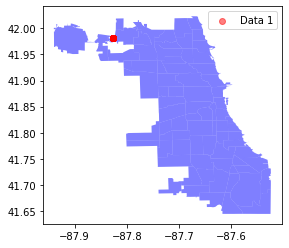

In [53]:
#das ganze visualisieren:
# Create a new figure and axis
fig, ax = plt.subplots()

# Plot the first GeoDataFrame
communities_gdf.plot(ax=ax, color='blue', alpha=0.5)

# Plot the second GeoDataFrame
unmatched_drop_com.plot(ax=ax, color='red', alpha=0.5)

# Add a legend
ax.legend(['Data 1', 'Data 2'])

# Show the plot
plt.show()

In [54]:
unmatched_drop_com.sort_values('dlat')

,dlong,dlat,geometry,index_right,area_num_1
273112,-87.826676,41.980507,POINT (-87.82668 41.98051),NaN,NaN
18168219,-87.826676,41.980507,POINT (-87.82668 41.98051),NaN,NaN
18127506,-87.826676,41.980507,POINT (-87.82668 41.98051),NaN,NaN
17979103,-87.826676,41.980507,POINT (-87.82668 41.98051),NaN,NaN
17977820,-87.826676,41.980507,POINT (-87.82668 41.98051),NaN,NaN
...,...,...,...,...,...
8188858,-87.826676,41.980507,POINT (-87.82668 41.98051),NaN,NaN
8188702,-87.826676,41.980507,POINT (-87.82668 41.98051),NaN,NaN
8188111,-87.826676,41.980507,POINT (-87.82668 41.98051),NaN,NaN
8692881,-87.826676,41.980507,POINT (-87.82668 41.98051),NaN,NaN


In [55]:
unmatched_drop_com.groupby('dlat').count()

,dlong,geometry,index_right,area_num_1
dlat,,,,
41.980507,400,400,0,0


In [56]:
df.loc[unmatched_drop_com.index,'Dropoff Community Area'].value_counts()

10.0    400
Name: Dropoff Community Area, dtype: int64

In [57]:
df.loc[unmatched_drop_com.index,'Dropoff Community Area']

273112      10.0
460602      10.0
460652      10.0
461243      10.0
509127      10.0
            ... 
24734578    10.0
24734874    10.0
24966555    10.0
24966872    10.0
24967149    10.0
Name: Dropoff Community Area, Length: 400, dtype: float64

In [58]:
matched_drop_comm_gdf.fillna(10,inplace=True)

In [59]:
mask=df['Dropoff Community Area'].notna()
test=df.loc[mask,'Dropoff Community Area'].astype('int')==matched_drop_comm_gdf.loc[mask,'area_num_1'].astype('int')

In [60]:
test.value_counts()

True    21212263
dtype: int64

In [61]:
#hier fuelle ich nun die daten in df. also die 14.983 fehlenden dropoff communitys
df.loc[matched_drop_comm_gdf.index,'Dropoff Community Area']=matched_drop_comm_gdf['area_num_1']

In [62]:
df.count()

Trip Start Timestamp          21276744
Trip End Timestamp            21276744
Trip Seconds                  21276744
Trip Miles                    21276744
Pickup Census Tract           16209492
Dropoff Census Tract          16209492
Pickup Community Area         21275553
Dropoff Community Area        21276744
Fare                          21276744
Tips                          21276744
Tolls                         21276744
Extras                        21276744
Trip Total                    21276744
Payment Type                  21276744
Company                       21276744
Pickup Centroid Latitude      21276744
Pickup Centroid Longitude     21276744
Pickup Centroid Location      21276744
Dropoff Centroid Latitude     21276744
Dropoff Centroid Longitude    21276744
Dropoff Centroid Location     21276744
new_TaxiID                    21276744
dur_min                       21276744
dtype: int64

In [63]:
#kreirt ein geopandas dataframe
geographical_pickup_gdf=gpd.GeoDataFrame(look[['plong','plat']], geometry=gpd.points_from_xy(look.plong, look.plat))

In [64]:
#sucht nach den Pickup communites der jeweiligen Pickup location, quasi ein merge, wenn die location innerhalb
#(within) einer community ist
matched_pick_comm_gdf = gpd.sjoin(geographical_pickup_gdf, communities_gdf[['area_num_1','geometry']], how='left', op='within')

/Users/SG/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-64-88b63e18aa74>:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  matched_pick_comm_gdf = gpd.sjoin(geographical_pickup_gdf, communities_gdf[['area_num_1','geometry']], how='left', op='within')


In [65]:
unmatched_pick_com=matched_pick_comm_gdf[matched_pick_comm_gdf['area_num_1'].isna()]

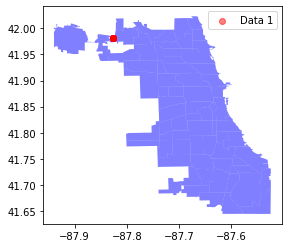

In [66]:
# Create a new figure and axis
fig, ax = plt.subplots()

# Plot the first GeoDataFrame
communities_gdf.plot(ax=ax, color='blue', alpha=0.5)

# Plot the second GeoDataFrame
unmatched_pick_com.plot(ax=ax, color='red', alpha=0.5)

# Add a legend
ax.legend(['Data 1', 'Data 2'])

# Show the plot
plt.show()

In [67]:
unmatched_pick_com

,plong,plat,geometry,index_right,area_num_1
2552842,-87.826676,41.980507,POINT (-87.82668 41.98051),NaN,NaN
4092718,-87.826676,41.980507,POINT (-87.82668 41.98051),NaN,NaN
8012406,-87.826676,41.980507,POINT (-87.82668 41.98051),NaN,NaN
11619289,-87.826676,41.980507,POINT (-87.82668 41.98051),NaN,NaN
12480512,-87.826676,41.980507,POINT (-87.82668 41.98051),NaN,NaN
12480563,-87.826676,41.980507,POINT (-87.82668 41.98051),NaN,NaN
15824611,-87.826676,41.980507,POINT (-87.82668 41.98051),NaN,NaN
15825516,-87.826676,41.980507,POINT (-87.82668 41.98051),NaN,NaN
17680467,-87.826676,41.980507,POINT (-87.82668 41.98051),NaN,NaN


In [68]:
df.loc[unmatched_pick_com.index,'Pickup Community Area']

2552842     10.0
4092718     10.0
8012406     10.0
11619289    10.0
12480512    10.0
12480563    10.0
15824611    10.0
15825516    10.0
17680467    10.0
Name: Pickup Community Area, dtype: float64

In [69]:
matched_pick_comm_gdf['area_num_1'].fillna(10,inplace=True)

In [70]:
mask=df['Pickup Community Area'].notna()
test=df.loc[mask,'Pickup Community Area'].astype('int')==matched_pick_comm_gdf.loc[mask,'area_num_1'].astype('int')

In [71]:
test.value_counts()

True    21275553
dtype: int64

In [72]:
#hier fuelle ich nun die daten in df. also die 162 fehlenden pickup communitys
df.loc[matched_pick_comm_gdf.index,'Pickup Community Area']=matched_pick_comm_gdf['area_num_1']

In [73]:
df.count()

Trip Start Timestamp          21276744
Trip End Timestamp            21276744
Trip Seconds                  21276744
Trip Miles                    21276744
Pickup Census Tract           16209492
Dropoff Census Tract          16209492
Pickup Community Area         21276744
Dropoff Community Area        21276744
Fare                          21276744
Tips                          21276744
Tolls                         21276744
Extras                        21276744
Trip Total                    21276744
Payment Type                  21276744
Company                       21276744
Pickup Centroid Latitude      21276744
Pickup Centroid Longitude     21276744
Pickup Centroid Location      21276744
Dropoff Centroid Latitude     21276744
Dropoff Centroid Longitude    21276744
Dropoff Centroid Location     21276744
new_TaxiID                    21276744
dur_min                       21276744
dtype: int64

# Füge die Wetter daten hinzu!

In [74]:
#wetterdatensatzladen
weather_df=pd.read_csv('extra_dataframes/weather_clean_final.csv',parse_dates=['date_time'])
weather_df=weather_df.drop('Unnamed: 0',axis=1)

In [75]:
# hier die timestamps abbrunden um gleich zusammenzufuehren
#also den datensatz ein bissche erweitern
weather_df.loc[:,'hour']=weather_df['date_time'].apply(lambda h :h.hour)
weather_df.loc[:,'day']=weather_df['date_time'].apply(lambda d :d.day)
weather_df.loc[:,'month']=weather_df['date_time'].apply(lambda m :m.month)

In [76]:
weather_df

,date_time,avg_temp,precip,hour,day,month
0,2017-01-01 00:00:00,-0.6,0.0,0,1,1
1,2017-01-01 01:00:00,-2.2,0.0,1,1,1
2,2017-01-01 02:00:00,-2.8,0.0,2,1,1
3,2017-01-01 03:00:00,-3.3,0.0,3,1,1
4,2017-01-01 04:00:00,-3.3,0.0,4,1,1
...,...,...,...,...,...,...
8755,2017-12-31 19:00:00,-11.1,0.0,19,31,12
8756,2017-12-31 20:00:00,-10.6,0.0,20,31,12
8757,2017-12-31 21:00:00,-10.6,0.0,21,31,12
8758,2017-12-31 22:00:00,-11.7,0.0,22,31,12


In [77]:
#hier soll gemerged werden, einmal werden die wetterdaten pro trip dazugeholt, dafuer hier
#erstmal neue columns erstellen mit der abgerundeten zeiten(stunde/monat/ etc)
#auch fuer spaetere analysen wichtig
df['date']=df['Trip Start Timestamp'].apply(lambda d: pd.to_datetime(d).floor('d'))
df['s_hour']=df['Trip Start Timestamp'].apply(lambda h: h.hour)
df['s_day']=df['Trip Start Timestamp'].apply(lambda d: d.day)
df['weekday']=df['Trip Start Timestamp'].apply(lambda w: w.dayofweek)
df['s_month']=df['Trip Start Timestamp'].apply(lambda m: m.month)

In [78]:
df=df.merge(weather_df[['avg_temp','precip','hour','day','month']],how='left',left_on=['s_hour','s_day','s_month'],right_on=['hour','day','month'])
df

,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,Fare,Tips,...,date,s_hour,s_day,weekday,s_month,avg_temp,precip,hour,day,month
0,2017-01-01 00:00:00,2017-01-01 00:30:00,1800.0,0.00,1.703108e+10,1.703108e+10,8,8,13.25,4.25,...,2017-01-01,0,1,6,1,-0.6,0.0,0,1,1
1,2017-01-01 00:00:00,2017-01-01 00:00:00,660.0,2.70,NaN,NaN,2,3,10.00,2.00,...,2017-01-01,0,1,6,1,-0.6,0.0,0,1,1
2,2017-01-01 00:00:00,2017-01-01 00:15:00,120.0,0.50,NaN,NaN,16,16,4.50,0.00,...,2017-01-01,0,1,6,1,-0.6,0.0,0,1,1
3,2017-01-01 00:00:00,2017-01-01 00:00:00,240.0,1.30,1.703184e+10,1.703183e+10,32,28,6.25,0.00,...,2017-01-01,0,1,6,1,-0.6,0.0,0,1,1
4,2017-01-01 00:00:00,2017-01-01 00:00:00,420.0,0.00,1.703128e+10,1.703184e+10,28,32,6.00,0.00,...,2017-01-01,0,1,6,1,-0.6,0.0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21276739,2017-12-31 23:45:00,2018-01-01 00:00:00,961.0,4.00,NaN,NaN,6,8,13.75,0.00,...,2017-12-31,23,31,6,12,-12.8,0.0,23,31,12
21276740,2017-12-31 23:45:00,2018-01-01 00:00:00,644.0,1.01,1.703108e+10,1.703108e+10,8,8,7.25,0.00,...,2017-12-31,23,31,6,12,-12.8,0.0,23,31,12
21276741,2017-12-31 23:45:00,2017-12-31 23:45:00,381.0,1.52,1.703124e+10,1.703184e+10,24,8,7.25,0.00,...,2017-12-31,23,31,6,12,-12.8,0.0,23,31,12
21276742,2017-12-31 23:45:00,2018-01-01 00:00:00,1116.0,5.50,NaN,NaN,8,6,17.25,3.85,...,2017-12-31,23,31,6,12,-12.8,0.0,23,31,12


In [79]:
#doppelte zeiten brauchen wir nicht
df.drop(['s_hour','s_day','s_month'],axis=1, inplace=True)

In [80]:
df.count()

Trip Start Timestamp          21276744
Trip End Timestamp            21276744
Trip Seconds                  21276744
Trip Miles                    21276744
Pickup Census Tract           16209492
Dropoff Census Tract          16209492
Pickup Community Area         21276744
Dropoff Community Area        21276744
Fare                          21276744
Tips                          21276744
Tolls                         21276744
Extras                        21276744
Trip Total                    21276744
Payment Type                  21276744
Company                       21276744
Pickup Centroid Latitude      21276744
Pickup Centroid Longitude     21276744
Pickup Centroid Location      21276744
Dropoff Centroid Latitude     21276744
Dropoff Centroid Longitude    21276744
Dropoff Centroid Location     21276744
new_TaxiID                    21276744
dur_min                       21276744
date                          21276744
weekday                       21276744
avg_temp                 

In [81]:
df.columns

Index(['Trip Start Timestamp', 'Trip End Timestamp', 'Trip Seconds',
       'Trip Miles', 'Pickup Census Tract', 'Dropoff Census Tract',
       'Pickup Community Area', 'Dropoff Community Area', 'Fare', 'Tips',
       'Tolls', 'Extras', 'Trip Total', 'Payment Type', 'Company',
       'Pickup Centroid Latitude', 'Pickup Centroid Longitude',
       'Pickup Centroid Location', 'Dropoff Centroid Latitude',
       'Dropoff Centroid Longitude', 'Dropoff Centroid Location', 'new_TaxiID',
       'dur_min', 'date', 'weekday', 'avg_temp', 'precip', 'hour', 'day',
       'month'],
      dtype='object')

In [82]:
df=df.rename(columns={'Dropoff Centroid Latitude': 'end_latitude','Dropoff Centroid Longitude': 'end_longitude'})
df=df.rename(columns={'Pickup Centroid Latitude': 'start_latitude','Pickup Centroid Longitude': 'start_longitude'})
df=df.rename(columns={'Trip Start Timestamp': 'start_time','Trip End Timestamp': 'end_time','Trip Seconds':'trip_seconds'})
df=df.rename(columns={'Payment Type': 'payment_type','Trips Total': 'cost_total','Trip Miles':'trip_miles'})
df=df.rename(columns={'Dropoff Community Area': 'end_community','Pickup Community Area': 'start_community'})
df=df.rename(columns={'Dropoff Census Tract': 'end_census','Pickup Census Tract': 'start_census'})
df=df.rename(columns={'Fare': 'fare','Tips': 'tips','Tolls':'tolls','Extras':'extras','Company':'company'})
df

,start_time,end_time,trip_seconds,trip_miles,start_census,end_census,start_community,end_community,fare,tips,...,Dropoff Centroid Location,new_TaxiID,dur_min,date,weekday,avg_temp,precip,hour,day,month
0,2017-01-01 00:00:00,2017-01-01 00:30:00,1800.0,0.00,1.703108e+10,1.703108e+10,8,8,13.25,4.25,...,POINT (-87.6262149064 41.8925077809),2751,30.00,2017-01-01,6,-0.6,0.0,0,1,1
1,2017-01-01 00:00:00,2017-01-01 00:00:00,660.0,2.70,NaN,NaN,2,3,10.00,2.00,...,POINT (-87.6558787862 41.96581197),5058,11.00,2017-01-01,6,-0.6,0.0,0,1,1
2,2017-01-01 00:00:00,2017-01-01 00:15:00,120.0,0.50,NaN,NaN,16,16,4.50,0.00,...,POINT (-87.7234523905 41.9535821253),5047,2.00,2017-01-01,6,-0.6,0.0,0,1,1
3,2017-01-01 00:00:00,2017-01-01 00:00:00,240.0,1.30,1.703184e+10,1.703183e+10,32,28,6.25,0.00,...,POINT (-87.6572331997 41.8852813201),2416,4.00,2017-01-01,6,-0.6,0.0,0,1,1
4,2017-01-01 00:00:00,2017-01-01 00:00:00,420.0,0.00,1.703128e+10,1.703184e+10,28,32,6.00,0.00,...,POINT (-87.6327464887 41.8809944707),3952,7.00,2017-01-01,6,-0.6,0.0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21276739,2017-12-31 23:45:00,2018-01-01 00:00:00,961.0,4.00,NaN,NaN,6,8,13.75,0.00,...,POINT (-87.6333080367 41.899602111),6515,16.02,2017-12-31,6,-12.8,0.0,23,31,12
21276740,2017-12-31 23:45:00,2018-01-01 00:00:00,644.0,1.01,1.703108e+10,1.703108e+10,8,8,7.25,0.00,...,POINT (-87.6207628651 41.8983317935),458,10.73,2017-12-31,6,-12.8,0.0,23,31,12
21276741,2017-12-31 23:45:00,2017-12-31 23:45:00,381.0,1.52,1.703124e+10,1.703184e+10,24,8,7.25,0.00,...,POINT (-87.6499072264 41.9049353016),746,6.35,2017-12-31,6,-12.8,0.0,23,31,12
21276742,2017-12-31 23:45:00,2018-01-01 00:00:00,1116.0,5.50,NaN,NaN,8,6,17.25,3.85,...,POINT (-87.6559981815 41.9442266014),973,18.60,2017-12-31,6,-12.8,0.0,23,31,12


In [83]:
df=df.rename(columns={'Trip Total': 'trip_total'})

In [84]:
df.to_csv('taxi_2017_complete_preprocessed.csv')

In [85]:
df.count()

start_time                   21276744
end_time                     21276744
trip_seconds                 21276744
trip_miles                   21276744
start_census                 16209492
end_census                   16209492
start_community              21276744
end_community                21276744
fare                         21276744
tips                         21276744
tolls                        21276744
extras                       21276744
trip_total                   21276744
payment_type                 21276744
company                      21276744
start_latitude               21276744
start_longitude              21276744
Pickup Centroid Location     21276744
end_latitude                 21276744
end_longitude                21276744
Dropoff Centroid Location    21276744
new_TaxiID                   21276744
dur_min                      21276744
date                         21276744
weekday                      21276744
avg_temp                     21276744
precip      

In [86]:
df

,start_time,end_time,trip_seconds,trip_miles,start_census,end_census,start_community,end_community,fare,tips,...,Dropoff Centroid Location,new_TaxiID,dur_min,date,weekday,avg_temp,precip,hour,day,month
0,2017-01-01 00:00:00,2017-01-01 00:30:00,1800.0,0.00,1.703108e+10,1.703108e+10,8,8,13.25,4.25,...,POINT (-87.6262149064 41.8925077809),2751,30.00,2017-01-01,6,-0.6,0.0,0,1,1
1,2017-01-01 00:00:00,2017-01-01 00:00:00,660.0,2.70,NaN,NaN,2,3,10.00,2.00,...,POINT (-87.6558787862 41.96581197),5058,11.00,2017-01-01,6,-0.6,0.0,0,1,1
2,2017-01-01 00:00:00,2017-01-01 00:15:00,120.0,0.50,NaN,NaN,16,16,4.50,0.00,...,POINT (-87.7234523905 41.9535821253),5047,2.00,2017-01-01,6,-0.6,0.0,0,1,1
3,2017-01-01 00:00:00,2017-01-01 00:00:00,240.0,1.30,1.703184e+10,1.703183e+10,32,28,6.25,0.00,...,POINT (-87.6572331997 41.8852813201),2416,4.00,2017-01-01,6,-0.6,0.0,0,1,1
4,2017-01-01 00:00:00,2017-01-01 00:00:00,420.0,0.00,1.703128e+10,1.703184e+10,28,32,6.00,0.00,...,POINT (-87.6327464887 41.8809944707),3952,7.00,2017-01-01,6,-0.6,0.0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21276739,2017-12-31 23:45:00,2018-01-01 00:00:00,961.0,4.00,NaN,NaN,6,8,13.75,0.00,...,POINT (-87.6333080367 41.899602111),6515,16.02,2017-12-31,6,-12.8,0.0,23,31,12
21276740,2017-12-31 23:45:00,2018-01-01 00:00:00,644.0,1.01,1.703108e+10,1.703108e+10,8,8,7.25,0.00,...,POINT (-87.6207628651 41.8983317935),458,10.73,2017-12-31,6,-12.8,0.0,23,31,12
21276741,2017-12-31 23:45:00,2017-12-31 23:45:00,381.0,1.52,1.703124e+10,1.703184e+10,24,8,7.25,0.00,...,POINT (-87.6499072264 41.9049353016),746,6.35,2017-12-31,6,-12.8,0.0,23,31,12
21276742,2017-12-31 23:45:00,2018-01-01 00:00:00,1116.0,5.50,NaN,NaN,8,6,17.25,3.85,...,POINT (-87.6559981815 41.9442266014),973,18.60,2017-12-31,6,-12.8,0.0,23,31,12


In [87]:
look=df[['start_latitude','start_longitude','end_latitude','end_longitude']]
look=look.rename(columns={'start_latitude':'plat','start_longitude':'plong','end_latitude':'dlat','end_longitude':'dlong'})


In [88]:
#nun das gleiche mit pickup und drop off cencus tract machen:
census=gpd.read_file('extra_dataframes/Census Tracts - 2010.geojson')

In [89]:
#geodrop = dropoffdata fuer den census tract dropoff
geodrop_gdf = gpd.GeoDataFrame(look, geometry=gpd.points_from_xy(look.dlong, look.dlat))
matched_gdf = gpd.sjoin(geodrop_gdf, census[['geoid10','geometry']], how='left', op='within')

/Users/SG/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-89-fb201ae4c96f>:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  matched_gdf = gpd.sjoin(geodrop_gdf, census[['geoid10','geometry']], how='left', op='within')


In [90]:
#hier sind alle unmatched variablen auch von chicago ohare. also kann ich die auch füllen mit chicago ohare 
#cencus trac mit nummer 17031980000
unmatched=matched_gdf[matched_gdf['geoid10'].isna()]
unmatched.sort_values(['dlat'])
#die 14983 fehlenden eintraege sind die gleiche, die bei der community area fehlen...

,plat,plong,dlat,dlong,geometry,index_right,geoid10
20408,41.892042,-87.631864,41.982775,-87.877305,POINT (-87.87731 41.98278),NaN,NaN
14718061,41.979071,-87.903040,41.982775,-87.877305,POINT (-87.87731 41.98278),NaN,NaN
14718802,41.979071,-87.903040,41.982775,-87.877305,POINT (-87.87731 41.98278),NaN,NaN
14718888,41.979071,-87.903040,41.982775,-87.877305,POINT (-87.87731 41.98278),NaN,NaN
14721147,41.979071,-87.903040,41.982775,-87.877305,POINT (-87.87731 41.98278),NaN,NaN
...,...,...,...,...,...,...,...
7859458,41.979071,-87.903040,41.982775,-87.877305,POINT (-87.87731 41.98278),NaN,NaN
7859589,41.979071,-87.903040,41.982775,-87.877305,POINT (-87.87731 41.98278),NaN,NaN
7859838,41.979071,-87.903040,41.982775,-87.877305,POINT (-87.87731 41.98278),NaN,NaN
7857261,41.979071,-87.903040,41.982775,-87.877305,POINT (-87.87731 41.98278),NaN,NaN


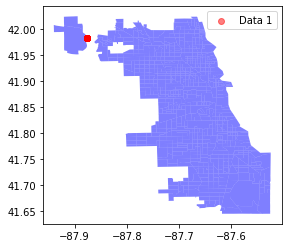

In [91]:
# Create a new figure and axis
fig, ax = plt.subplots()

# Plot the first GeoDataFrame
census.plot(ax=ax, color='blue', alpha=0.5)

# Plot the second GeoDataFrame
unmatched.plot(ax=ax, color='red', alpha=0.5)

# Add a legend
ax.legend(['Data 1', 'Data 2'])

# Show the plot
plt.show()

In [92]:
unmatched.groupby('dlat').count()

,plat,plong,dlong,geometry,index_right,geoid10
dlat,,,,,,
41.982775,64481,64481,64481,64481,0,0


In [93]:
df.loc[unmatched.index,'end_census'].value_counts()

1.703177e+10    64481
Name: end_census, dtype: int64

In [94]:
#17031770700 is der census trac, der in dem datensatz census fehlt, und in dem sie eigentlich sind
#17031980000 is der census trac von chicago ohare, zu dem die dropoffs quasi zaehlen...
matched_gdf['geoid10'].fillna(17031770700, inplace=True)


In [95]:
#testen ob die alten mit den neuen tract uebereinstimmen!
mask=df['end_census'].notna()
test=df.loc[mask,'end_census'].astype('int')==matched_gdf.loc[mask,'geoid10'].astype('int')

In [96]:
test.value_counts()

True    16209492
dtype: int64

In [97]:
#jetzt kann ich uebertragen
df.loc[:,'end_census']=matched_gdf['geoid10']

In [98]:
df.count()

start_time                   21276744
end_time                     21276744
trip_seconds                 21276744
trip_miles                   21276744
start_census                 16209492
end_census                   21276744
start_community              21276744
end_community                21276744
fare                         21276744
tips                         21276744
tolls                        21276744
extras                       21276744
trip_total                   21276744
payment_type                 21276744
company                      21276744
start_latitude               21276744
start_longitude              21276744
Pickup Centroid Location     21276744
end_latitude                 21276744
end_longitude                21276744
Dropoff Centroid Location    21276744
new_TaxiID                   21276744
dur_min                      21276744
date                         21276744
weekday                      21276744
avg_temp                     21276744
precip      

In [99]:
#geopick = pickupdata fuer den census tract pickup
geopick_gdf = gpd.GeoDataFrame(look, geometry=gpd.points_from_xy(look.plong, look.plat))
matched_gdf = gpd.sjoin(geopick_gdf, census[['geoid10','geometry']], how='left', op='within')

/Users/SG/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-99-37a7629ca517>:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  matched_gdf = gpd.sjoin(geopick_gdf, census[['geoid10','geometry']], how='left', op='within')


In [100]:
#hier sind alle unmatched variablen auch von chicago ohare. also kann ich die auch füllen mit chicago ohare 
#cencus trac mit nummer 17031770700
unmatchedp=matched_gdf[matched_gdf['geoid10'].isna()]
unmatchedp.sort_values(['plat'])
#die 14983 fehlenden eintraege sind die gleiche, die bei der community area fehlen...

,plat,plong,dlat,dlong,geometry,index_right,geoid10
28776,41.982775,-87.877305,41.885300,-87.642808,POINT (-87.87731 41.98278),NaN,NaN
14604064,41.982775,-87.877305,41.982775,-87.877305,POINT (-87.87731 41.98278),NaN,NaN
14603981,41.982775,-87.877305,41.899156,-87.626211,POINT (-87.87731 41.98278),NaN,NaN
14558888,41.982775,-87.877305,41.979071,-87.903040,POINT (-87.87731 41.98278),NaN,NaN
14558064,41.982775,-87.877305,41.982775,-87.877305,POINT (-87.87731 41.98278),NaN,NaN
...,...,...,...,...,...,...,...
7458843,41.982775,-87.877305,41.892508,-87.626215,POINT (-87.87731 41.98278),NaN,NaN
7452490,41.982775,-87.877305,41.982775,-87.877305,POINT (-87.87731 41.98278),NaN,NaN
7391113,41.982775,-87.877305,41.982775,-87.877305,POINT (-87.87731 41.98278),NaN,NaN
7388176,41.982775,-87.877305,41.982775,-87.877305,POINT (-87.87731 41.98278),NaN,NaN


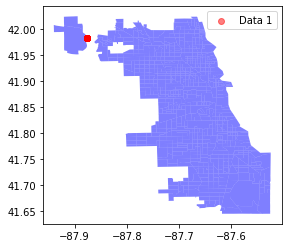

In [101]:
#das ganze visualisieren:
# Create a new figure and axis
fig, ax = plt.subplots()

# Plot the first GeoDataFrame
census.plot(ax=ax, color='blue', alpha=0.5)

# Plot the second GeoDataFrame
unmatchedp.plot(ax=ax, color='red', alpha=0.5)

# Add a legend
ax.legend(['Data 1', 'Data 2'])

# Show the plot
plt.show()

In [102]:
#anscheinend sind alle anfaenge genau gleich
unmatchedp.groupby('plat').count()

,plong,dlat,dlong,geometry,index_right,geoid10
plat,,,,,,
41.982775,1191,1191,1191,1191,0,0


In [103]:
#welcher census tract fehlt?
df.loc[unmatchedp.index,'start_census'].value_counts()

1.703177e+10    1191
Name: start_census, dtype: int64

In [104]:
unmatchedp

,plat,plong,dlat,dlong,geometry,index_right,geoid10
28776,41.982775,-87.877305,41.885300,-87.642808,POINT (-87.87731 41.98278),NaN,NaN
35643,41.982775,-87.877305,41.979071,-87.903040,POINT (-87.87731 41.98278),NaN,NaN
90032,41.982775,-87.877305,41.982775,-87.877305,POINT (-87.87731 41.98278),NaN,NaN
90229,41.982775,-87.877305,41.982775,-87.877305,POINT (-87.87731 41.98278),NaN,NaN
90411,41.982775,-87.877305,41.982775,-87.877305,POINT (-87.87731 41.98278),NaN,NaN
...,...,...,...,...,...,...,...
21073913,41.982775,-87.877305,41.982775,-87.877305,POINT (-87.87731 41.98278),NaN,NaN
21077538,41.982775,-87.877305,41.884987,-87.620993,POINT (-87.87731 41.98278),NaN,NaN
21077992,41.982775,-87.877305,41.982775,-87.877305,POINT (-87.87731 41.98278),NaN,NaN
21100221,41.982775,-87.877305,41.979071,-87.903040,POINT (-87.87731 41.98278),NaN,NaN


In [105]:
df.loc[unmatchedp.index,'start_census']

28776       1.703177e+10
35643       1.703177e+10
90032       1.703177e+10
90229       1.703177e+10
90411       1.703177e+10
                ...     
21073913    1.703177e+10
21077538    1.703177e+10
21077992    1.703177e+10
21100221    1.703177e+10
21194815    1.703177e+10
Name: start_census, Length: 1191, dtype: float64

In [106]:
#nun also die fehlenden werte auffuellen mit 17031770700
matched_gdf['geoid10'].fillna(17031770700, inplace=True)

In [107]:
#testen ob die alten mit den neuen tract uebereinstimmen!
mask=df['start_census'].notna()
test=df.loc[mask,'start_census'].astype('int')==matched_gdf.loc[mask,'geoid10'].astype('int')

In [108]:
test.value_counts()

True    16209492
dtype: int64

In [109]:
#jetzt kann ich uebertragen
df.loc[:,'start_census']=matched_gdf['geoid10']

In [110]:
df.count()

start_time                   21276744
end_time                     21276744
trip_seconds                 21276744
trip_miles                   21276744
start_census                 21276744
end_census                   21276744
start_community              21276744
end_community                21276744
fare                         21276744
tips                         21276744
tolls                        21276744
extras                       21276744
trip_total                   21276744
payment_type                 21276744
company                      21276744
start_latitude               21276744
start_longitude              21276744
Pickup Centroid Location     21276744
end_latitude                 21276744
end_longitude                21276744
Dropoff Centroid Location    21276744
new_TaxiID                   21276744
dur_min                      21276744
date                         21276744
weekday                      21276744
avg_temp                     21276744
precip      

In [111]:
df.to_csv('taxi_2017_preprocessed_with_census.csv')

In [112]:
df.count()

start_time                   21276744
end_time                     21276744
trip_seconds                 21276744
trip_miles                   21276744
start_census                 21276744
end_census                   21276744
start_community              21276744
end_community                21276744
fare                         21276744
tips                         21276744
tolls                        21276744
extras                       21276744
trip_total                   21276744
payment_type                 21276744
company                      21276744
start_latitude               21276744
start_longitude              21276744
Pickup Centroid Location     21276744
end_latitude                 21276744
end_longitude                21276744
Dropoff Centroid Location    21276744
new_TaxiID                   21276744
dur_min                      21276744
date                         21276744
weekday                      21276744
avg_temp                     21276744
precip      